In [1]:
import json
import math
import os
import keras
import cv2
import tensorflow as tf

from PIL import Image
import numpy as np
import seaborn as sns
from keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import scipy
import tensorflow 
from tqdm import tqdm

%matplotlib inline

### Upload Data

In [3]:
train_df = pd.read_csv("C:/Users/U53R/Documents/THESIS/10-Fold/train/x_train_9.xls")
valid_df = pd.read_csv("C:/Users/U53R/Documents/THESIS/10-Fold/test/x_valid_9.xls")
print(train_df.shape)
print(valid_df.shape)
train_df.head()

(3297, 2)
(365, 2)


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

diagnosis
0    1625
2     899
1     333
4     266
3     174
Name: count, dtype: int64
Axes(0.125,0.11;0.775x0.77)


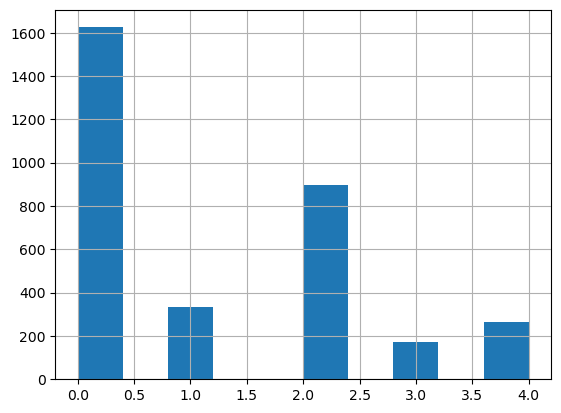

In [4]:
print(train_df['diagnosis'].value_counts())
print(train_df['diagnosis'].hist())

diagnosis
0    180
2    100
1     37
4     29
3     19
Name: count, dtype: int64
Axes(0.125,0.11;0.775x0.77)


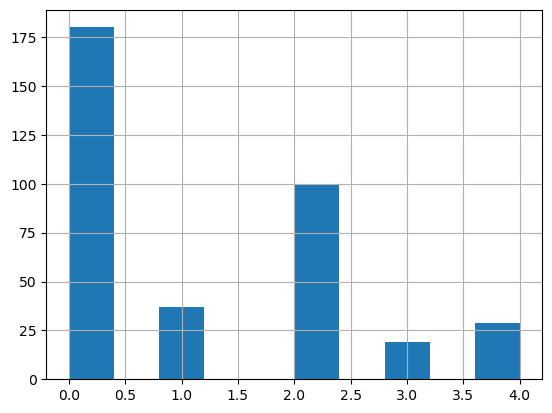

In [5]:
print(valid_df['diagnosis'].value_counts())
print(valid_df['diagnosis'].hist())

### Visualize Image

In [7]:
x = train_df['id_code']
y = train_df['diagnosis']

IMG_SIZE = 224
SEED = 2021

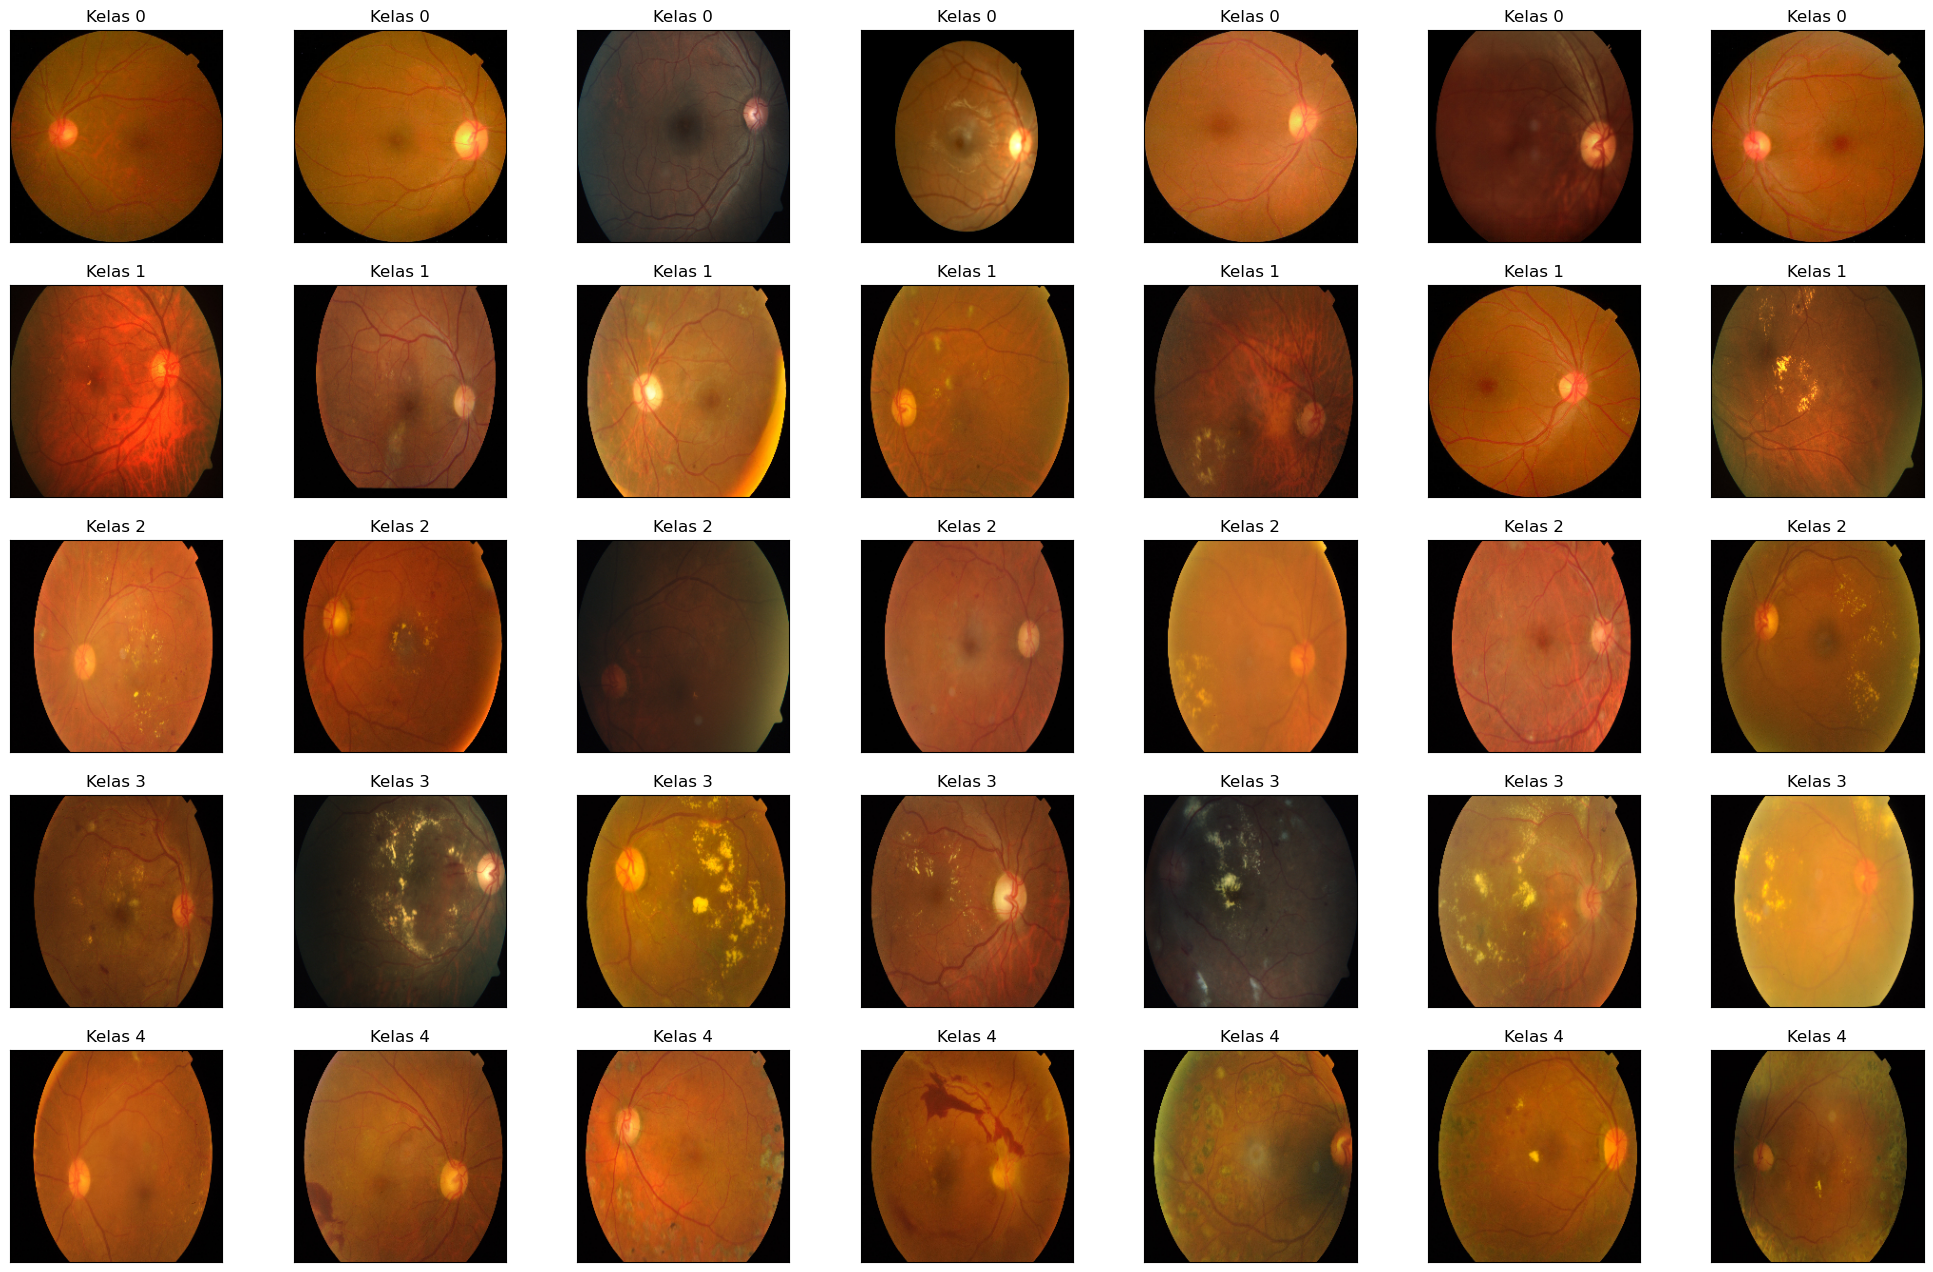

In [8]:
NUM_SAMP = 7

fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y.unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"C:/Users/U53R/Documents/THESIS/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        plt.imshow(image)
        ax.set_title('Kelas %d' % (class_id))

In [19]:
y

0       2
1       4
2       1
3       0
4       0
       ..
3292    2
3293    0
3294    2
3295    0
3296    2
Name: diagnosis, Length: 3297, dtype: int64

## Sample

In [80]:
#resample
from sklearn.utils import resample
X=train_df
normal=X[X.diagnosis==0]
mild=X[X.diagnosis==1]
moderate=X[X.diagnosis==2]
severe=X[X.diagnosis==3]
pdr=X[X.diagnosis==4]

#downsampled
mild = resample(mild,
                replace=True, # sample with replacement
                n_samples=700, # match number in majority class
                random_state=2021) # reproducible results
moderate = resample(moderate,
                    replace=False, # sample with replacement
                    n_samples=700, # match number in majority class
                    random_state=2021) # reproducible results
severe = resample(severe,
                  replace=True, # sample with replacement
                  n_samples=700, # match number in majority class
                  random_state=2021) # reproducible results
normal = resample(normal,
                  replace=False, # sample with replacement
                  n_samples=700, # match number in majority class
                  random_state=2021) # reproducible results
pdr = resample(pdr,
               replace=True, # sample with replacement
               n_samples=700, # match number in majority class
               random_state=2021) # reproducible results    

# combine minority and downsampled majority
sampled = pd.concat([normal, mild, moderate, severe, pdr])

train_df = sampled
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [82]:
print(train_df.shape)
print(valid_df.shape)

(3500, 2)
(365, 2)


### Image Preprocessing

Circular Cropping

In [86]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [88]:
def circle_crop(img, sigmaX=10):

    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    return img

In [90]:
def preprocess_image(path, sigmaX=10):
    img = cv2.imread(path)
    img = crop_image_from_gray(img)
    # img = circle_crop(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert RGB
    r, g, b = cv2.split(img) #memisahkan 3 kanal warna
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8)) #CLAHE
    # img = clahe.apply(r) #channel red
    img = clahe.apply(g) #channel green
    # img = clahe.apply(b) #channel blue
    # img = cv2.merge((b,img,r)) #gabung
    img = np.stack([img]*3, axis=-1) #stack 3 kanal
    img = cv2.resize(img, (224,224))
    
    return img

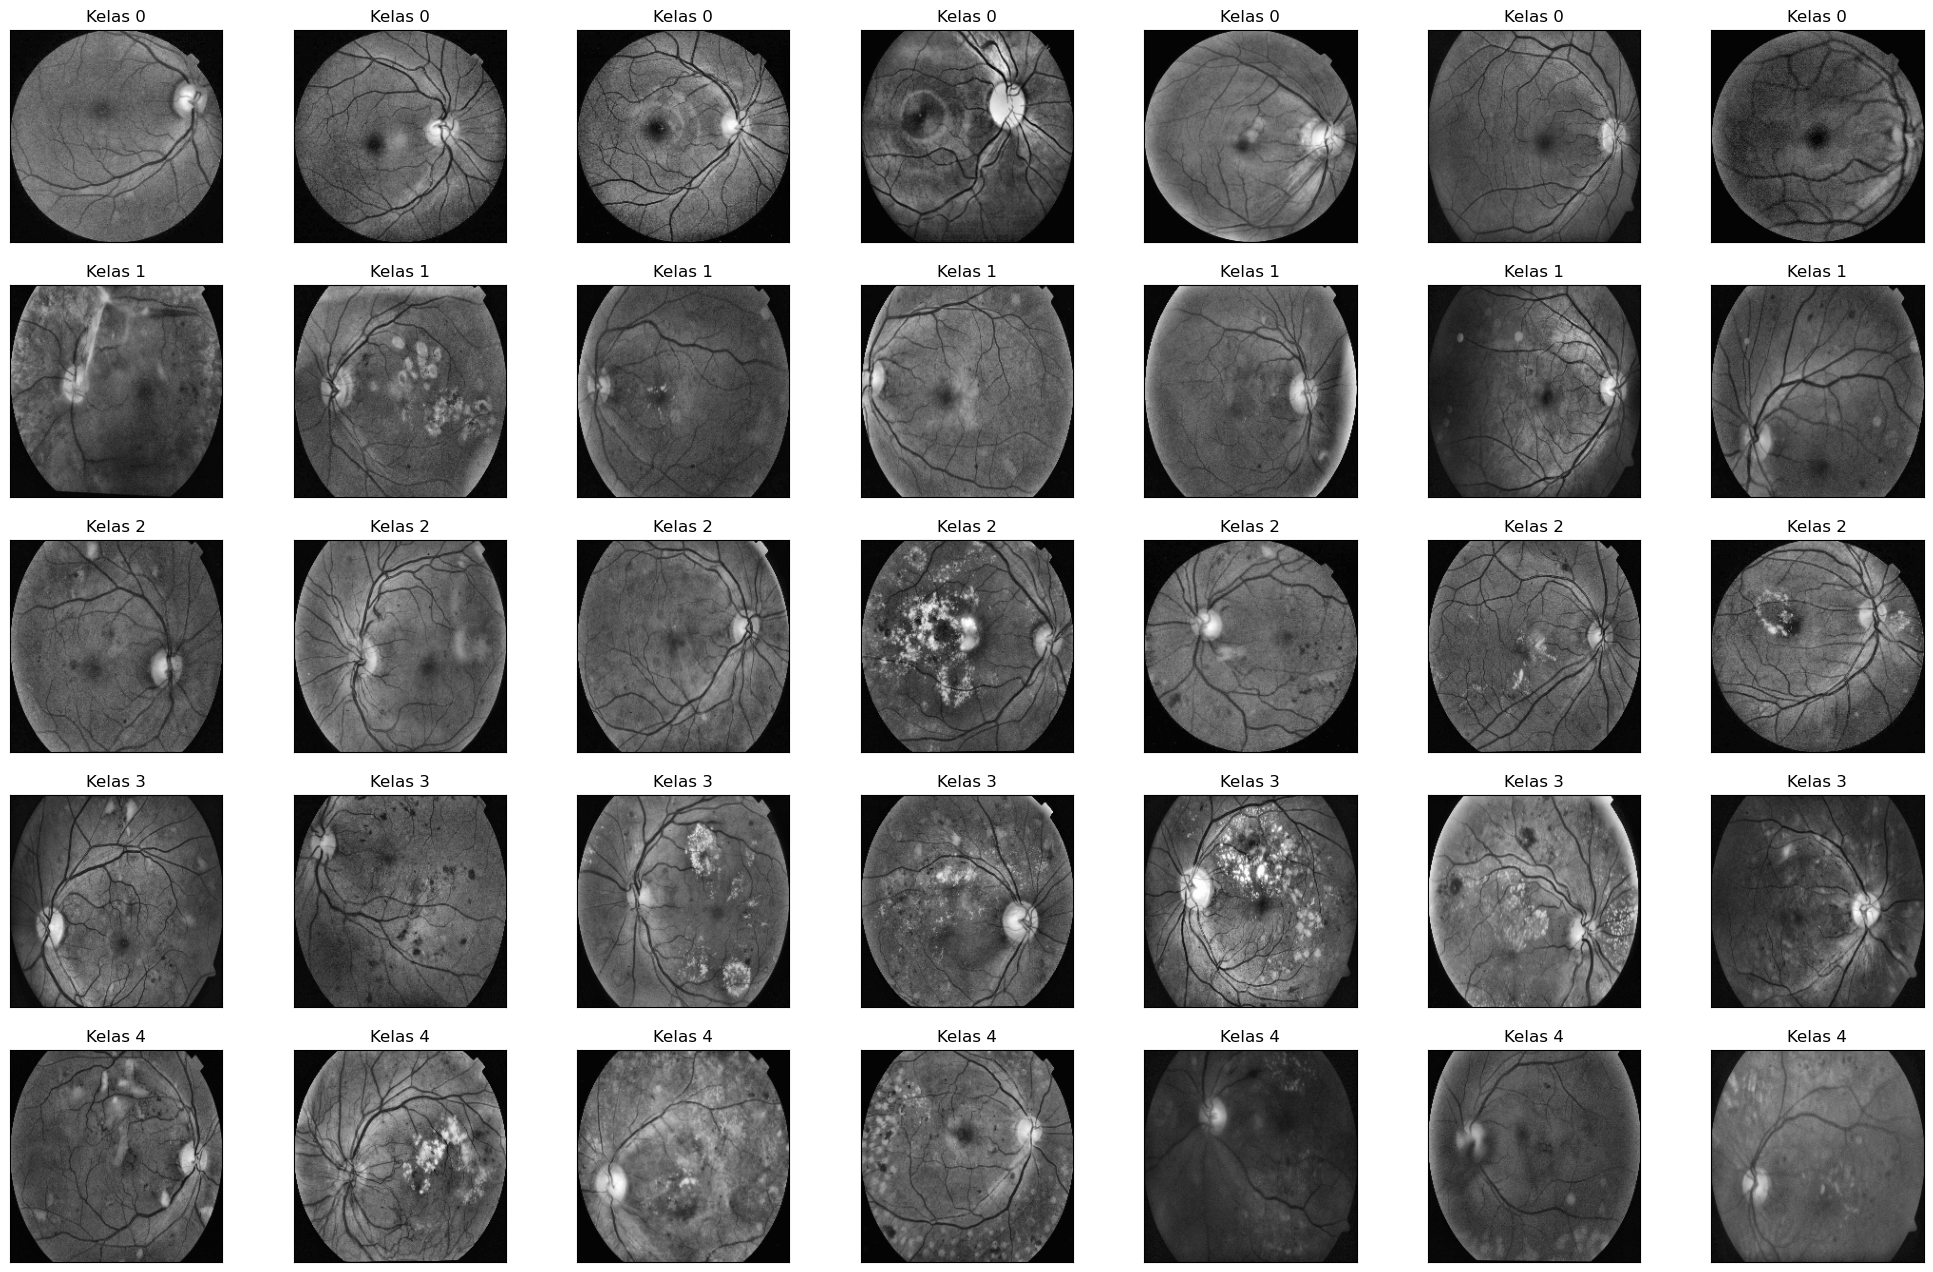

In [92]:
NUM_SAMP=7
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(y.unique()):
    for i, (idx, row) in enumerate(train_df.loc[train_df['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED ).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"C:/Users/U53R/Documents/THESIS/aptos2019-blindness-detection/train_images/{row['id_code']}.png"
        image = preprocess_image(path,sigmaX=10)

        plt.imshow(image)
        ax.set_title('Kelas %d' % (class_id) )

In [94]:
image.shape

(224, 224, 3)

In [96]:
N = train_df.shape[0]
x_train = np.empty((N, 224,224, 3), dtype=np.float32)

for i, image_id in enumerate(tqdm(train_df['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        f'C:/Users/U53R/Documents/THESIS/aptos2019-blindness-detection/train_images/{image_id}.png')

N = valid_df.shape[0]
x_valid = np.empty((N, 224,224, 3), dtype=np.float32)

for i, image_id in enumerate(tqdm(valid_df['id_code'])):
    x_valid[i, :, :, :] = preprocess_image(
        f'C:/Users/U53R/Documents/THESIS/aptos2019-blindness-detection/train_images/{image_id}.png')

100%|██████████| 365/365 [01:52<00:00,  3.25it/s]


In [97]:
y_train = tensorflow.keras.utils.to_categorical(train_df['diagnosis'], num_classes=5)
y_valid = tensorflow.keras.utils.to_categorical(valid_df['diagnosis'], num_classes=5)

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(3500, 224, 224, 3)
(3500, 5)
(365, 224, 224, 3)
(365, 5)


In [98]:
print(np.min(x_train), np.max(x_train))
print(np.min(y_train), np.max(y_train))
print('-------------------------------')
print(np.min(x_valid), np.max(x_valid))
print(np.min(y_valid), np.max(y_valid))

1.0 255.0
0.0 1.0
-------------------------------
1.0 255.0
0.0 1.0


## Augmentation

In [100]:
# from tensorflow.keras.applications.resnet50 import preprocess_input

# x_train = preprocess_input(x_train)
# x_valid = preprocess_input(x_valid)

In [102]:
BATCH_SIZE = 32

datagen = ImageDataGenerator(
        zoom_range=0.9,  # set range for random zoom
        rotation_range = 45, # set range for random rotation
        # fill_mode='constant',
        # cval=0,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )
data_generator = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [103]:
print(np.min(x_train), np.max(x_train))
print(np.min(y_train), np.max(y_train))
print('-------------------------------')
print(np.min(x_valid), np.max(x_valid))
print(np.min(y_valid), np.max(y_valid))

1.0 255.0
0.0 1.0
-------------------------------
1.0 255.0
0.0 1.0


In [104]:
# class_weights = {0: 0.40578462,
#                 1: 1.98018018,
#                 2: 0.73348165,
#                 3: 3.78965517,
#                 4: 2.47894737}

### Build Model

In [106]:
# from keras import layers
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.layers import Flatten, Dropout, Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler

base_model = ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    include_top=False,   # Do not include the top (fully connected) layers
    input_shape=(224, 224, 3)
)

# Add custom top layers for our specific task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

# Combine the base model and the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a custom learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [107]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 24,586,245 (93.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

### Training dan Evaluation

In [109]:
import time

start_time = time.time()

history = model.fit(
    data_generator,
    steps_per_epoch=int(x_train.shape[0] / 32),
    epochs=100,
    validation_data=(x_valid, y_valid)
    # class_weight=class_weights
)

C:\Users\U53R\anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 2237s 20s/step - accuracy: 0.3514 - loss: 1.6142 - val_accuracy: 0.7014 - val_loss: 0.7997
Epoch 2/100
  1/109 ━━━━━━━━━━━━━━━━━━━━ 30:15 17s/step - accuracy: 0.4375 - loss: 1.2541

C:\Users\U53R\anaconda\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


109/109 ━━━━━━━━━━━━━━━━━━━━ 64s 438ms/step - accuracy: 0.4375 - loss: 1.2541 - val_accuracy: 0.6959 - val_loss: 0.8368
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 2229s 20s/step - accuracy: 0.5113 - loss: 1.1443 - val_accuracy: 0.7151 - val_loss: 0.7936
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 78s 554ms/step - accuracy: 0.5000 - loss: 1.1042 - val_accuracy: 0.7151 - val_loss: 0.7936
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 2257s 21s/step - accuracy: 0.5586 - loss: 1.0501 - val_accuracy: 0.7836 - val_loss: 0.5893
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 74s 528ms/step - accuracy: 0.6875 - loss: 0.7984 - val_accuracy: 0.7863 - val_loss: 0.5922
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 2199s 20s/step - accuracy: 0.5977 - loss: 0.9894 - val_accuracy: 0.7342 - val_loss: 0.8968
Epoch 8/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 79s 544ms/step - accuracy: 0.5938 - loss: 0.9080 - val_accuracy: 0.7370 - val_loss: 0.8529
Epoch 9/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 2195s 20s/step - accuracy: 0.6073 - loss: 0.956

In [110]:
end_time = time.time()

training_time = end_time - start_time
print(f"Waktu pelatihan: {training_time} detik")

Waktu pelatihan: 108147.23184370995 detik


In [130]:
# Simpan model ke disk
model.save("D:/THESIS/JURNAL/DRAFT THESIS/MobileNet/fold-green kanal/resnet/fold_9.h5")

12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step
Accuracy Valid: 0.7232876712328767


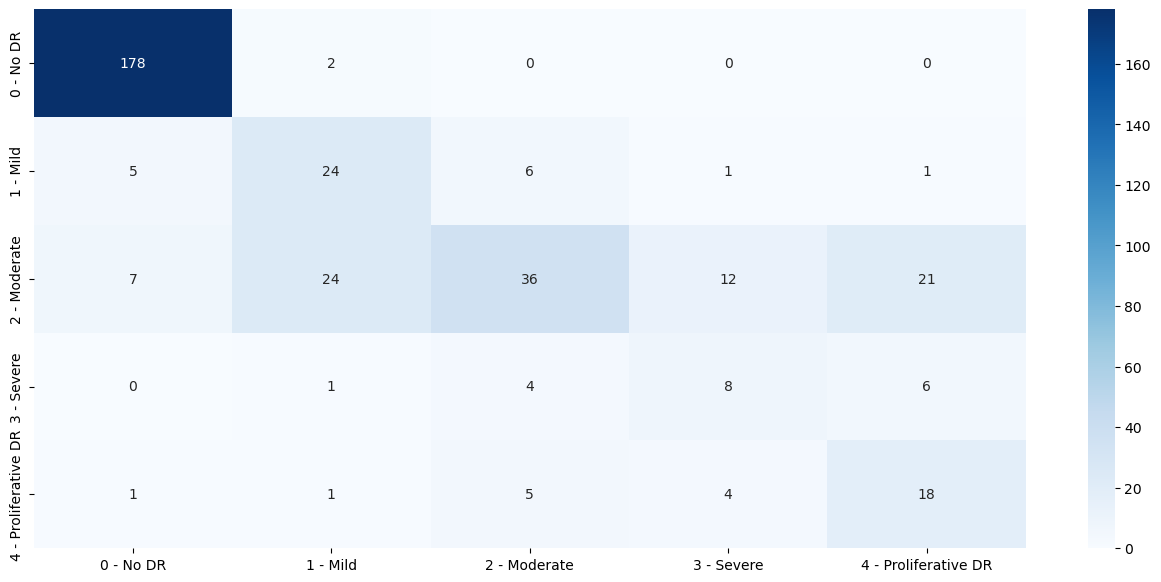

In [113]:
from sklearn.metrics import roc_auc_score

pred = model.predict(x_valid)
y_pred_classes = np.argmax(pred, axis=1)
y_true_classes = np.argmax(y_valid, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Accuracy Valid: {accuracy}")

labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
cnf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
df_cm = pd.DataFrame(cnf_matrix, index=labels, columns=labels)
plt.figure(figsize=(16, 7))
sns.heatmap(df_cm, annot=True, fmt='.0f', cmap="Blues")
plt.show()

In [114]:
from sklearn.metrics import classification_report
target_names = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

                      precision    recall  f1-score   support

           0 - No DR       0.93      0.99      0.96       180
            1 - Mild       0.46      0.65      0.54        37
        2 - Moderate       0.71      0.36      0.48       100
          3 - Severe       0.32      0.42      0.36        19
4 - Proliferative DR       0.39      0.62      0.48        29

            accuracy                           0.72       365
           macro avg       0.56      0.61      0.56       365
        weighted avg       0.75      0.72      0.72       365

